In [21]:
import numpy as np
import bilby
import pandas as pd
import matplotlib.pyplot as plt

# Make prior samples

In [2]:
priors = bilby.core.prior.PriorDict(dict(
    m=bilby.core.prior.TruncatedNormal(mu=0, sigma=1, minimum=0, maximum=3, name="m"),
    c=bilby.core.prior.Uniform(-5, 5, name="c"),
))

In [3]:
pd.DataFrame(priors.sample(10_000))

15:08 bilby WARNING : Prior sampling efficiency is very low, please verify its validity.


,m,c
0,0.419768,-1.829018
1,1.501871,-2.578877
2,1.335776,1.378660
3,1.152268,-4.841413
4,0.187465,3.921882
...,...,...
9995,0.872997,2.956348
9996,0.658750,-3.077713
9997,0.556182,0.361398
9998,0.509790,-1.395951


15:08 bilby WARNING : Prior sampling efficiency is very low, please verify its validity.


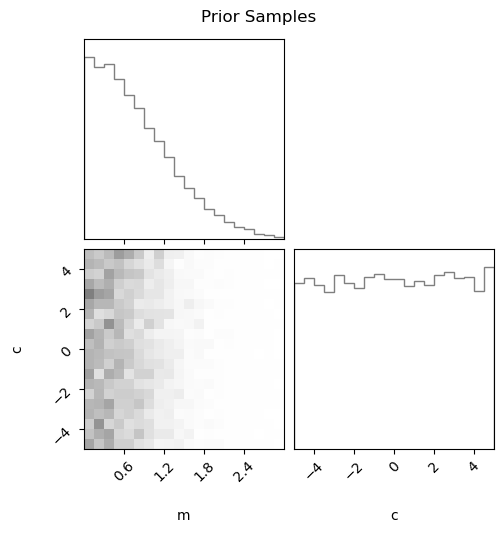

In [4]:
from corner import corner
fig = corner(
    pd.DataFrame(priors.sample(10000)),
    plot_datapoints=False, 
    plot_contours=False, plot_density=True,
    color="tab:gray",
    labels=list(priors.keys()),
)
fig.suptitle("Prior Samples");

# Define likelihood and sampler

**Load observation and time data**

In [10]:
df = pd.read_csv('../data/01_raw/observation_time.csv')

time, observation = df["time"].to_numpy(), df["observation"].to_numpy()

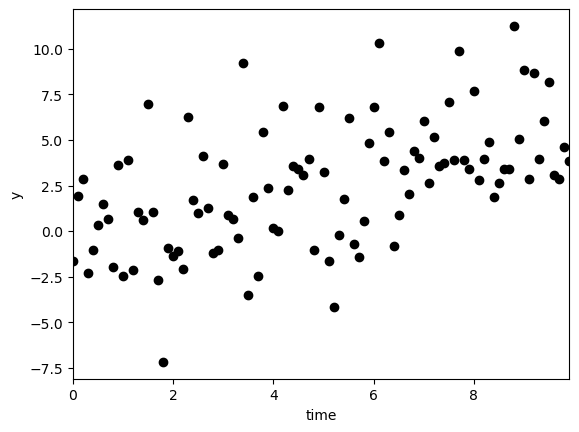

In [23]:
def plot_data(ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(time, observation, "o", color='k', zorder=-10)
    ax.set_xlabel("time")
    ax.set_ylabel("y");
    ax.set_xlim(min(time), max(time))

plot_data()

**Define the signal model**

In [13]:
def signal_model(time, m, c):
        return time * m + c

**Define the likelihood**

In [14]:
likelihood = bilby.likelihood.GaussianLikelihood(time, observation, signal_model, sigma=3)

**Define and run the sampler**

In [15]:
OUTDIR = '../data/08_reporting/results.csv'
def sampler_run():
    result = bilby.run_sampler(
        likelihood=likelihood,
        priors=priors,
        sampler="dynesty",
        nlive=500,
        sample="unif",
        outdir=OUTDIR,
        label="linear_regression",
    )
    return result

sampler_result = sampler_run()

15:14 bilby INFO    : Running for label 'linear_regression', output will be saved to '../data/08_reporting/results.csv'
15:14 bilby INFO    : Analysis priors:
15:14 bilby INFO    : m=TruncatedNormal(mu=0, sigma=1, minimum=0, maximum=3, name='m', latex_label='m', unit=None, boundary=None)
15:14 bilby INFO    : c=Uniform(minimum=-5, maximum=5, name='c', latex_label='c', unit=None, boundary=None)
15:14 bilby INFO    : Analysis likelihood class: <class 'bilby.core.likelihood.GaussianLikelihood'>
15:14 bilby INFO    : Analysis likelihood noise evidence: nan
15:14 bilby INFO    : Single likelihood evaluation took 3.578e-05 s
15:14 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 500, 'bound': 'live', 'sample': 'unif', 'periodic': None, 'reflective': None, 'update_interval': 600, 'first_update': None, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None

3170it [00:01, 2316.79it/s, bound:5 nc:  3 ncall:2.0e+04 eff:16.2% logz=-253.23+/-0.08 dlogz:0.127>0.1]

15:14 bilby INFO    : Written checkpoint file ../data/08_reporting/results.csv/linear_regression_resume.pickle


3284it [00:03, 1049.42it/s, bound:5 nc:  1 ncall:2.0e+04 eff:19.2% logz=-253.11+/-0.08 dlogz:0.000191>0.1]

15:14 bilby INFO    : Rejection sampling nested samples to obtain 1320 posterior samples
15:14 bilby INFO    : Sampling time: 0:00:03.128209


15:14 bilby INFO    : Summary of results:
nsamples: 1320
ln_noise_evidence:    nan
ln_evidence: -253.113 +/-  0.103
ln_bayes_factor:    nan +/-  0.103



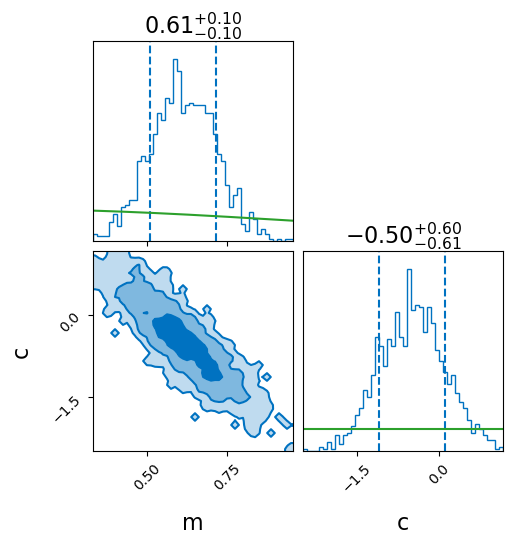

In [18]:
fig = sampler_result.plot_corner(priors=True, save=False)

**Check how well the model performs on the data**

In [25]:
def plot_model_on_data(samples, plot_each_sample=False, color="tab:blue", ax=None, label="model"):
    m, c = samples['m'], samples['c']
    
    ys = np.array([signal_model(time, mi, ci) for mi, ci in zip(m, c)]).T
    
    if ax is None:
        fig, ax = plt.subplots()

    y_low, y_mean, y_up = np.quantile(ys, [0.05, 0.5, 0.95], axis=1)
    ax.plot(time, y_mean, color=color, label=f"{label} mean")
    ax.fill_between(time, y_low, y_up, alpha=0.1, color=color, label=f"{label} 90%")

    if plot_each_sample:
        for y in ys.T:
            ax.plot(time, y, color=color, alpha=0.1)
        
    plot_data(ax)
    ax.legend(frameon=True, fontsize=12)
    return ax.get_figure()


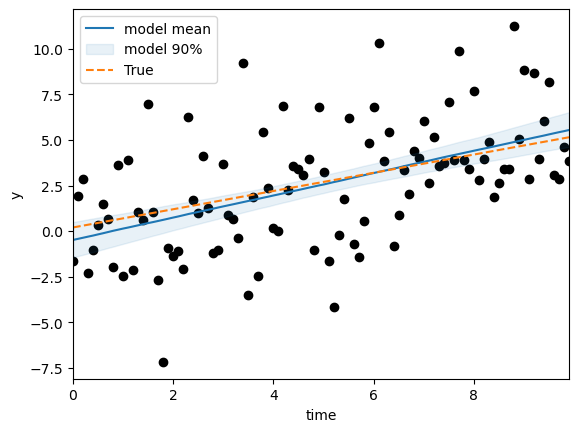

In [26]:
truths = {'c': 0.2, 'm': 0.5, 'sigma': 3}

fig = plot_model_on_data(sampler_result.posterior.sample(1000))
fig.axes[0].plot(time, signal_model(time, m=truths['m'], c=truths['c']), color="tab:orange", ls='--', label="True")
fig.axes[0].legend();